# EAS2655: Week 9 Temperature trend map
Pengfei Liu
pengfei.liu@eas.gatech.edu

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import scipy.stats as stats

### load NCEP reanalysis data 

In [3]:
# load netcdf data
fn='./air.mon.mean.nc'
ds=xr.open_dataset(fn)
# select time range
TMP=ds.air.sel(time=slice("1948-01-01","2020-12-31"))
TMP

<xarray.DataArray 'air' (time: 876, lat: 73, lon: 144)>
[9208512 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 90.0 87.5 85.0 82.5 80.0 ... -82.5 -85.0 -87.5 -90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time     (time) datetime64[ns] 1948-01-01 1948-02-01 ... 2020-12-01
Attributes:
    long_name:     Monthly Mean Air Temperature at sigma level 0.995
    valid_range:   [-2000.  2000.]
    units:         degC
    precision:     1
    var_desc:      Air Temperature
    level_desc:    Surface
    statistic:     Mean
    parent_stat:   Individual Obs
    dataset:       NCEP Reanalysis Derived Products
    actual_range:  [-73.78001  42.14595]

### work with NETCDF data

In [39]:
# get dimension
nlat=TMP.lat.size
nlon=TMP.lon.size

# calculate annual mean
TMP_year=TMP.groupby('time.year').mean('time')
TMP_year

# Optional: one more example: get data for July
mon=7
TMP_July=TMP.sel(time=TMP['time.month']==mon)
year_val=TMP_July['time.year'].values



## Exercise 1: calculate and plot the linear trend for each grid cell

### define a function to calculate correlation coefficient and slope

In [10]:
def regrcorr(X,Y):
    C=np.cov(X,Y)
    # slope
    a=np.empty(2)
    a[0]=C[0,1]/C[0,0]
    # intercept
    a[1]=np.mean(Y)-a[0]*np.mean(X)
    # correlation coefficient
    r=C[0,1]/np.sqrt(C[0,0]*C[1,1])    
    return a, r

## calculate the linear trend for each grid cell

In [43]:
slope=np.empty((nlat,nlon))
r_mat=np.empty((nlat,nlon))

xx=TMP_year.year.values

for ii in np.arange(0,nlon):
    for jj in np.arange(0,nlat):
        yy=TMP_year.isel(lat=jj,lon=ii).values
        a,r=regrcorr(xx,yy)
        slope[jj,ii]=a[0]
        r_mat[jj,ii]=r

In [44]:
# re-assemble the data array 
da1=xr.DataArray(data=r_mat,dims=['lat','lon'],coords=dict(lat=TMP_year.lat,lon=TMP_year.lon),name='r')
da2=xr.DataArray(data=slope,dims=['lat','lon'],coords=dict(lat=TMP_year.lat,lon=TMP_year.lon),name='slope')

# optional: merge data arrays into a new dataset and save it in netcdf format 
ds_out=xr.merge([da1,da2])
ds_out.to_netcdf('./ncep_r_slope.nc')
ds_out

<xarray.Dataset>
Dimensions:  (lat: 73, lon: 144)
Coordinates:
  * lat      (lat) float32 90.0 87.5 85.0 82.5 80.0 ... -82.5 -85.0 -87.5 -90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Data variables:
    r        (lat, lon) float64 0.8002 0.8002 0.8002 ... 0.7941 0.7941 0.7941
    slope    (lat, lon) float64 0.06563 0.06563 0.06563 ... 0.06881 0.06881

### Let's visualize the result

<xarray.DataArray 'slope' ()>
array(0.10990416)
<xarray.DataArray 'slope' ()>
array(-0.06280255)


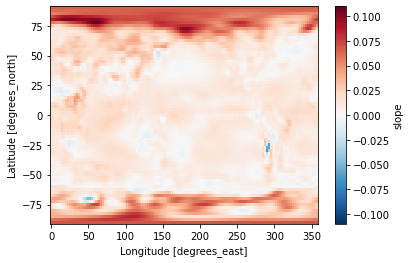

In [50]:
da2.plot()

print(da2.max())
print(da2.min())

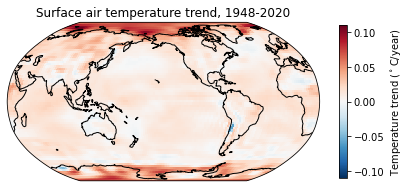

In [73]:
# make it nicer
#plot global temperature trend map
X=da2.lon.values
Y=da2.lat.values
Z=da2.values

# grid boundaries
Xb=np.arange(-2.5/2, 360,2.5)
Yb=np.arange(90-2.5/2, -90,-2.5)
Yb=np.append(90,Yb)
Yb=np.append(Yb,-90)

fig=plt.figure(figsize=(7, 4))
ax = plt.axes(projection=ccrs.Robinson(central_longitude=-150))
ax.coastlines()
cf=ax.pcolormesh(Xb,Yb,Z, transform=ccrs.PlateCarree(),vmin=-0.11,vmax=0.11,cmap='RdBu_r',rasterized=True)
plt.colorbar(cf, ax=ax,shrink=0.7, label='Temperature trend ($^\circ$C/year)')

ax.set_title('Surface air temperature trend, 1948-2020')

fn='Fig_global_annual_trend_Robinson'
plt.savefig('./fig/'+fn+'.pdf',bbox_inches="tight",dpi=300)
plt.savefig('./fig/'+fn+'.png',bbox_inches="tight",dpi=300)
plt.show()

## Exercise 2: add significance tests

In [75]:
def regrcorr2(X,Y,CL):
    C=np.cov(X,Y)
    # slope
    a=np.empty(2)
    a[0]=C[0,1]/C[0,0]
    # intercept
    a[1]=np.mean(Y)-a[0]*np.mean(X)
    # correlation coefficient
    r=C[0,1]/np.sqrt(C[0,0]*C[1,1])    
    # sample size
    N=np.size(Y)    
    # lag-1 autocorrelation for Y
    y0=Y[0:-1]
    y1=Y[1:]
    Cy=np.cov(y0,y1)
    r1=Cy[0,1]/np.sqrt(Cy[0,0]*Cy[1,1])
    # effective sample size
    Neff=N*(1-r1)/(1+r1)
    Neff=min(N,Neff)
    # SE of regression
    Y_pred=a[0]*X+a[1]
    err2=sum(np.square(Y-Y_pred))/(Neff-2)
    SE2=err2/sum(np.square(X-np.mean(X)))
    SE=np.sqrt(SE2)
    # calculate tcrit (two-tailed)
    tcrit=stats.t.ppf((1+CL)/2,Neff-2)
    CI=tcrit*SE
    return a,r,CI,Neff  

In [80]:
# Are these slopes significantly different from zero?
# two-tailed t-test for slope

slope=np.empty((nlat,nlon))
r_mat=np.empty((nlat,nlon))
confint=np.empty((nlat,nlon))
Neff_mat=np.empty((nlat,nlon))

xx=TMP_year.year.values
CL=0.95

for ii in np.arange(0,nlon):
    for jj in np.arange(0,nlat):
        yy=TMP_year.isel(lat=jj,lon=ii).values
        a,r,CI,Neff=regrcorr2(xx,yy,CL)
        slope[jj,ii]=a[0]
        r_mat[jj,ii]=r
        confint[jj,ii]=CI
        Neff_mat[jj,ii]=Neff



In [81]:
# if significant, trdsig=1; otherwise, trdsig=0;
trdsig=np.zeros((nlat,nlon))
trdsig[confint<np.abs(slope)]=1

In [82]:
# re-assemble the data array 
da1=xr.DataArray(data=r_mat,dims=['lat','lon'],coords=dict(lat=TMP_year.lat,lon=TMP_year.lon),name='r')
da2=xr.DataArray(data=slope,dims=['lat','lon'],coords=dict(lat=TMP_year.lat,lon=TMP_year.lon),name='slope')
da3=xr.DataArray(data=confint,dims=['lat','lon'],coords=dict(lat=TMP_year.lat,lon=TMP_year.lon),name='CI')
da4=xr.DataArray(data=Neff_mat,dims=['lat','lon'],coords=dict(lat=TMP_year.lat,lon=TMP_year.lon),name='Neff')
da5=xr.DataArray(data=trdsig,dims=['lat','lon'],coords=dict(lat=TMP_year.lat,lon=TMP_year.lon),name='trdsig')

# optional: merge data arrays into a new dataset and save it in netcdf format 
ds_out=xr.merge([da1,da2,da3,da4,da5])
ds_out.to_netcdf('./ncep_r_slope_sig.nc')
ds_out

<xarray.Dataset>
Dimensions:  (lat: 73, lon: 144)
Coordinates:
  * lat      (lat) float32 90.0 87.5 85.0 82.5 80.0 ... -82.5 -85.0 -87.5 -90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Data variables:
    r        (lat, lon) float64 0.8002 0.8002 0.8002 ... 0.7941 0.7941 0.7941
    slope    (lat, lon) float64 0.06563 0.06563 0.06563 ... 0.06881 0.06881
    CI       (lat, lon) float64 0.05739 0.05739 0.05739 ... 0.04083 0.04083
    Neff     (lat, lon) float64 6.91 6.91 6.91 6.91 ... 10.63 10.63 10.63 10.63
    trdsig   (lat, lon) float64 1.0 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0

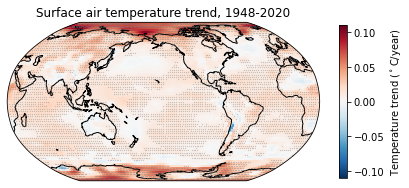

In [74]:
#plot global temperature trend map
X=da2.lon.values
Y=da2.lat.values
Z=da2.values

X_mat,Y_mat=np.meshgrid(X,Y)
ind_plot=(trdsig==1)

# grid boundaries
Xb=np.arange(-2.5/2, 360,2.5)
Yb=np.arange(90-2.5/2, -90,-2.5)
Yb=np.append(90,Yb)
Yb=np.append(Yb,-90)

fig=plt.figure(figsize=(7, 4))
ax = plt.axes(projection=ccrs.Robinson(central_longitude=-150))
ax.coastlines()
cf=ax.pcolormesh(Xb,Yb,Z, transform=ccrs.PlateCarree(),vmin=-0.11,vmax=0.11,cmap='RdBu_r',rasterized=True)
plt.colorbar(cf, ax=ax,shrink=0.7, label='Temperature trend ($^\circ$C/year)')

plt.plot(X_mat[ind_plot],Y_mat[ind_plot], '.',color='gray',markersize=0.3, transform=ccrs.PlateCarree())

ax.set_title('Surface air temperature trend, 1948-2020')

fn='Fig_global_annual_trend_Robinson_sig'
plt.savefig('./fig/'+fn+'.pdf',bbox_inches="tight",dpi=300)
plt.savefig('./fig/'+fn+'.png',bbox_inches="tight",dpi=300)
plt.show()

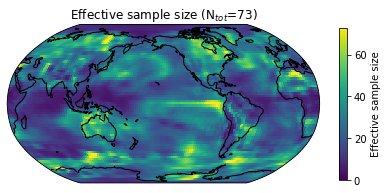

In [88]:
#plot global temperature trend map
X=da2.lon.values
Y=da2.lat.values
Z=Neff_mat

# grid boundaries
Xb=np.arange(-2.5/2, 360,2.5)
Yb=np.arange(90-2.5/2, -90,-2.5)
Yb=np.append(90,Yb)
Yb=np.append(Yb,-90)

fig=plt.figure(figsize=(7, 4))
ax = plt.axes(projection=ccrs.Robinson(central_longitude=-150))
ax.coastlines()
cf=ax.pcolormesh(Xb,Yb,Z, transform=ccrs.PlateCarree(),vmin=0,vmax=73,cmap='viridis',rasterized=True)
plt.colorbar(cf, ax=ax,shrink=0.7, label='Effective sample size')

ax.set_title('Effective sample size (N$_{tot}$=73)')

fn='Fig_global_Neff_map'
plt.savefig('./fig/'+fn+'.pdf',bbox_inches="tight",dpi=300)
plt.savefig('./fig/'+fn+'.png',bbox_inches="tight",dpi=300)
plt.show()